In [1]:
import xarray as xr
import numpy as np
import datetime

In [2]:
#we want to run our model for different dates
t0_i = datetime.datetime(2018,7,28,0)
t0_f = datetime.datetime(2018,7,31,18)
delta_h = 6
# number of forecast steps
num_steps = 4 * 15 # 6h intervals

init_times = []
current_time = t0_i
while current_time <= t0_f:
    init_times.append(current_time)
    current_time += datetime.timedelta(hours=delta_h)

models = ['awi-cm-1-1-mr', 'bcc-csm2-mr', 'cams-csm1-0', 'canesm5-1', 'cas-esm2-0', 'cmcc-cm2-hr4', \
          'cmcc-cm2-sr5', 'cmcc-esm2', 'ec-earth3-cc', 'ec-earth3-veg-lr', 'ec-earth3-veg','ec-earth3']

In [3]:
#load data
var='t2m'
var_inits_model = []
for model in models:
    print(model)
    var_inits = []
    for t0 in init_times:

        yyyymmddhh = t0.strftime('%Y%m%d%H')    
        file = f'/home/bernatj/Data/ai-forecasts/fcst/{yyyymmddhh}/{var}_fcnv2_PGW_{model}_{yyyymmddhh}.nc'
        ds = xr.open_dataset(file)[var]
        var_inits.append(ds)

    var_inits_model.append(xr.concat(var_inits, dim='init_time'))

merged_dataset = xr.concat(var_inits_model, dim='model')

    

awi-cm-1-1-mr
bcc-csm2-mr
cams-csm1-0
canesm5-1
cas-esm2-0
cmcc-cm2-hr4
cmcc-cm2-sr5
cmcc-esm2
ec-earth3-cc
ec-earth3-veg-lr
ec-earth3-veg
ec-earth3


In [4]:
# Add coordinates for the new dimension
merged_dataset = merged_dataset.assign_coords(init_time=init_times)
merged_dataset = merged_dataset.assign_coords(model=models)

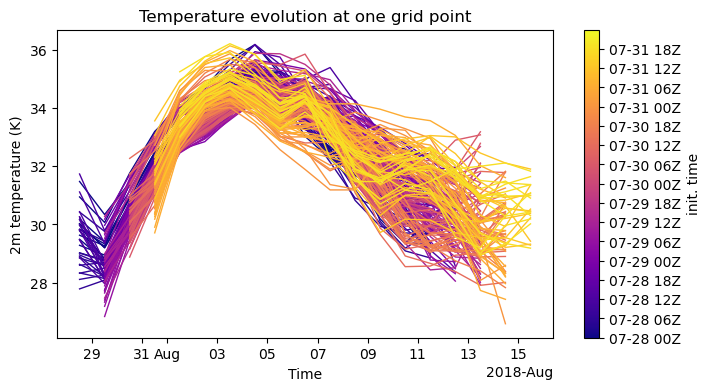

In [5]:
import matplotlib.pyplot as plt
import numpy as np


def plot_temp_evolution(merged_dataset, init_times, models):
    """
    Plots the temperature evolution at one grid point along with shading between the 10th and 90th percentiles.

    Args:
    - merged_dataset (xarray.Dataset): A dataset containing the merged temperature data.
    - init_times (list): A list of initialization times.

    Returns:
    - None

    Example usage:
    plot_temp_evolution(merged_dataset, init_times)
    """

    # Define a colormap that starts from blue and gradually moves towards red
    cmap = plt.get_cmap('plasma')

    # Normalize initialization times to range from 0 to 1
    norm = plt.Normalize(0, len(init_times))

    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=(8,4))

    # Iterate over each initialization time
    for i, init in enumerate(init_times):
        for j, model in enumerate(models):
        # Calculate the color based on the normalized index
            color = cmap(norm(i))
            slice_data = merged_dataset.sel(model=model, init_time=init) -273.15
            # Select data slice and plot with custom color
            slice_data[2::4].plot(color=color, ax=ax, lw=1, ls='-')

    # Plot the average
    #ens_mean = merged_dataset.mean('init_time') -273.15 
    #ens_max = merged_dataset.max('init_time') -273.15
    #ens_min = merged_dataset.min('init_time') -273.15
    #ens_p90 = merged_dataset.quantile(0.75,'init_time') -273.15
    #ens_p10 = merged_dataset.quantile(0.25,'init_time') -273.15
#
    #ens_mean[2::4].plot(color='k', ax=ax, lw=2)
    #ax.fill_between(ens_min[2::4]['time'], ens_min[2::4], ens_max[2::4], color='k', alpha=0.1)
    #ax.fill_between(ens_min[2::4]['time'], ens_p10[2::4], ens_p90[2::4], color='k', alpha=0.2)

    # Customize the plot
    ax.set_title("Temperature evolution at one grid point")
    ax.set_xlabel("Time")
    ax.set_ylabel("2m temperature (K)")

    # Create a colorbar manually
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, label="init. time")
    cbar.set_ticks(np.arange(0, len(init_times)))

    # Format the init_times to show only MM-DD HHUTC
    init_time_labels = [time.strftime('%m-%d %HZ') for time in init_times]
    cbar.set_ticklabels(init_time_labels)

    plt.show()

plot_temp_evolution(merged_dataset[:,:,:,200, -15], init_times, models)



In [6]:
#read era5 data
dir = '/home/bernatj/Data/my_data/era5/hourly/t2m/t2m-era5-hourly-2018*.nc'
t2m_era5 = xr.open_mfdataset(dir).t2m
t2m_era5 = t2m_era5.rename({'latitude' : 'lat', 'longitude' : 'lon'}) 


In [7]:
#load data

var='t2m'
var_inits = []
for t0 in init_times:

    yyyymmddhh = t0.strftime('%Y%m%d%H')    
    file = f'/home/bernatj/Data/ai-forecasts/fcst/{yyyymmddhh}/{var}_fcnv2_{yyyymmddhh}.nc'
    ds = xr.open_dataset(file)[var]
    var_inits.append(ds)

merged_dataset_factual = xr.concat(var_inits, dim='init_time')
    

In [8]:
def flip_lon_360_2_180(var_360, lon):
    """
    This function shifts the longitude dimension from [0,360] to [-180,180].
    """
    try:
        var_180 = var_360.assign_coords(lon=(lon + 180) % 360 - 180)
        var_180 = var_180.sortby(var_180.lon)
    except:
        var_180 = var_360.assign_coords(longitude=(lon + 180) % 360 - 180)
        var_180 = var_180.sortby(var_180.longitude)

    return var_180

import regionmask

def add_country_mask(ds: xr.Dataset, country: str="Spain") -> xr.Dataset:

    # get countries mask
    countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110

    # create mask variable
    mask = countries.mask_3D(ds)

    # select Spain mask
    var_name = country.lower()
    ds[f"{var_name}_mask"] = mask.isel(region=(mask.names=="Spain")).squeeze().astype(np.int16)

    return ds

def add_land_mask(ds: xr.Dataset) -> xr.Dataset:

    # get land-sea-mask mask
    land_110 = regionmask.defined_regions.natural_earth_v5_0_0.land_110
    # create land mask variable
    ds["land_mask"] = land_110.mask_3D(ds).squeeze().astype(np.int16)

    return ds

In [9]:
t2m_era5_max_iberia = add_land_mask(flip_lon_360_2_180(t2m_era5[12::24],t2m_era5.lon).sel(time=slice('2018-07-28','2018-08-15'), lat=slice(50,30),lon=slice(-12,9))).load() -273.15
t2m_era5_max_iberia_masked = t2m_era5_max_iberia.where(t2m_era5_max_iberia["land_mask"]==1, drop=True)

In [10]:
t2m_ai = merged_dataset
t2m_ai_fac = merged_dataset_factual

In [11]:
t2m_ai_max_iberia = add_land_mask(flip_lon_360_2_180(t2m_ai[:,:,2::4], t2m_ai.lon).sel(lat=slice(50,30), lon=slice(-12,8))) -273.15
t2m_ai_max_iberia_masked = t2m_ai_max_iberia.where(t2m_ai_max_iberia["land_mask"]==1, drop=True)

In [12]:
t2m_ai_fac_max_iberia = add_land_mask(flip_lon_360_2_180(t2m_ai_fac[:,2::4], t2m_ai_fac.lon).sel(lat=slice(50,30), lon=slice(-12,8))) -273.15
t2m_ai_fac_max_iberia_masked = t2m_ai_fac_max_iberia.where(t2m_ai_fac_max_iberia["land_mask"]==1, drop=True)

In [13]:
#average over iberia:
t2m_era5_max_iberia_avg = t2m_era5_max_iberia_masked.sel(lat=slice(43,36),lon=slice(-9,3)).mean('lon').mean('lat')
t2m_ai_max_iberia_avg = t2m_ai_max_iberia_masked.sel(lat=slice(43,36),lon=slice(-9,3)).mean('lon').mean('lat')
t2m_ai_fac_max_iberia_avg = t2m_ai_fac_max_iberia_masked.sel(lat=slice(43,36),lon=slice(-9,3)).mean('lon').mean('lat')

In [16]:
diff_atrib_models = t2m_ai_fac_max_iberia_avg.mean('init_time') - t2m_ai_max_iberia_avg.mean('init_time')

Text(0.5, 1.0, 'Factual vs. Counterfactual 2m-Temperature at 12UTC [36-43$^{\\circ}$N, 9$^{\\circ}$W-3$^{\\circ}$E]')

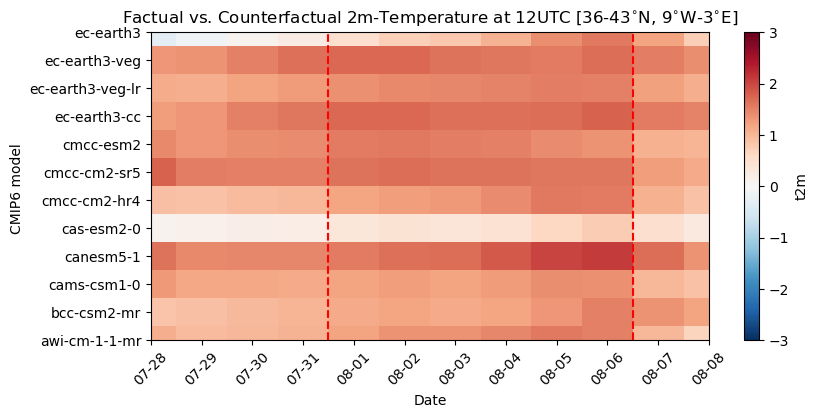

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a new figure with desired size
fig, ax = plt.subplots(figsize=(9, 4))
ax.set_facecolor('0.8')
# Plot t2m_era5_max_iberia_avg
diff_atrib_models[0:12].transpose('model','time').plot(ax=ax, cmap='RdBu_r', vmax=3, vmin=-3)

# Add vertical lines at August 1 and August 7
# Convert date strings to datetime objects
aug_1 = pd.to_datetime('2018-08-01')
aug_7 = pd.to_datetime('2018-08-07')

# Add a filled background between the vertical lines
ax.axvline(x=aug_1, color='r', linestyle='--')
ax.axvline(x=aug_7, color='r', linestyle='--')

# Set the x-axis tick positions to the middle of the raster boxes
ax.set_xticks(diff_atrib_models[0:12].time)
# Set the tick labels to the desired dates
ax.set_xticklabels(diff_atrib_models[0:12].time.dt.strftime('%m-%d').values)

# Rotate the tick labels for better readability
plt.xticks(rotation=45)

# Add labels and title
ax.set_xlabel('Date')
ax.set_ylabel('CMIP6 model ')
ax.set_title('Factual vs. Counterfactual 2m-Temperature at 12UTC [36-43$^{\circ}$N, 9$^{\circ}$W-3$^{\circ}$E]')

#plt.savefig('BIAS_init_vs_time_2018HW_Iberia_FourCastNet_wrt_ERA5.pdf',bbox_inches='tight')
#plt.savefig('BIAS_init_vs_time_2018HW_Iberia_FourCastNet_wrt_ERA5.png')

In [28]:
# Plot the average
ens_mean = t2m_ai_max_iberia_avg.mean(dim=['init_time', 'model'])  
ens_max = t2m_ai_max_iberia_avg.max(dim=['init_time', 'model']) 
ens_min = t2m_ai_max_iberia_avg.min(dim=['init_time', 'model']) 
ens_p95 = t2m_ai_max_iberia_avg.quantile(0.95,dim=['init_time', 'model']) 
ens_p5 = t2m_ai_max_iberia_avg.quantile(0.05,dim=['init_time', 'model']) 
ens_p75 = t2m_ai_max_iberia_avg.quantile(0.75,dim=['init_time', 'model']) 
ens_p25 = t2m_ai_max_iberia_avg.quantile(0.25,dim=['init_time', 'model']) 

ens_mean_fac = t2m_ai_fac_max_iberia_avg.mean(dim=['init_time'])  
ens_max_fac = t2m_ai_fac_max_iberia_avg.max(dim=['init_time']) 
ens_min_fac = t2m_ai_fac_max_iberia_avg.min(dim=['init_time']) 
ens_p95_fac = t2m_ai_fac_max_iberia_avg.quantile(0.95,dim=['init_time']) 
ens_p5_fac = t2m_ai_fac_max_iberia_avg.quantile(0.05,dim=['init_time']) 
ens_p75_fac = t2m_ai_fac_max_iberia_avg.quantile(0.75,dim=['init_time']) 
ens_p25_fac = t2m_ai_fac_max_iberia_avg.quantile(0.25,dim=['init_time']) 

Text(0.5, 1.0, 'Iberian mean 2m-Temperature at 12UTC [36-43$^{\\circ}$N, 9$^{\\circ}$W-3$^{\\circ}$E]')

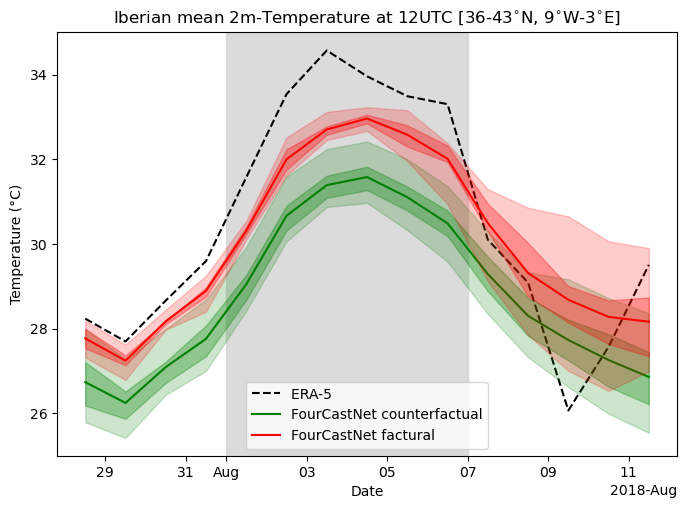

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a new figure with desired size
fig, ax = plt.subplots(figsize=(8, 5.5))

# Plot t2m_era5_max_iberia_avg
t2m_era5_max_iberia_avg[0:15].plot(ax=ax, label='ERA-5 ', color='k', linestyle='--')

# Plot t2m_ai_max_iberia_avg
ens_mean[0:15].plot(ax=ax, label='FourCastNet counterfactual', color='g', linestyle='-', zorder=102)
ax.fill_between(ens_p5['time'][0:15], ens_p5[0:15], ens_p95[0:15], color='g', alpha=0.2, zorder=101)
ax.fill_between(ens_p5['time'][0:15], ens_p25[0:15], ens_p75[0:15], color='g', alpha=0.3, zorder=100)
#ens_max[0:15].plot(ax=ax, color='g', linestyle=':', zorder=102)
#ens_min[0:15].plot(ax=ax, color='g', linestyle=':', zorder=102)

#factual world
ens_mean_fac[0:15].plot(ax=ax, label='FourCastNet factural', color='r', linestyle='-', zorder=202)
ax.fill_between(ens_min_fac['time'][0:15], ens_min_fac[0:15], ens_p95_fac[0:15], color='r', alpha=0.2, zorder=201)
ax.fill_between(ens_min_fac['time'][0:15], ens_p25_fac[0:15], ens_p75_fac[0:15], color='r', alpha=0.3, zorder=200)
#ens_max_fac[0:15].plot(ax=ax, color='r', linestyle=':', zorder=102)
#ens_min_fac[0:15].plot(ax=ax, color='r', linestyle=':', zorder=102)


# Add vertical lines at August 1 and August 7
# Convert date strings to datetime objects
aug_1 = pd.to_datetime('2018-08-01')
aug_7 = pd.to_datetime('2018-08-07')

# Add a filled background between the vertical lines
ax.axvspan(aug_1, aug_7, color='lightgray', alpha=0.8)

# Add legend
ax.legend(fontsize=10)

ax.set_ylim([25,35])

# Add labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (°C)')
ax.set_title('Iberian mean 2m-Temperature at 12UTC [36-43$^{\circ}$N, 9$^{\circ}$W-3$^{\circ}$E]')

#plt.savefig('plot_HW2018_atribution_12CMIP6_deltas_16inits_Iberian_landmean_2.pdf')


In [32]:
#calculate bias:
ens_mean_iberia = t2m_ai_max_iberia.mean('init_time').mean('model')  
ens_mean_iberia_fac = t2m_ai_fac_max_iberia.mean('init_time')  

t2m_ai_bias_iberia = (ens_mean_iberia_fac - t2m_era5_max_iberia).load()
t2m_ai_pgw_iberia = (ens_mean_iberia_fac - ens_mean_iberia).load()

/tmp/ipykernel_4171164/1491209380.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = mpl.cm.get_cmap('RdBu_r', 256)


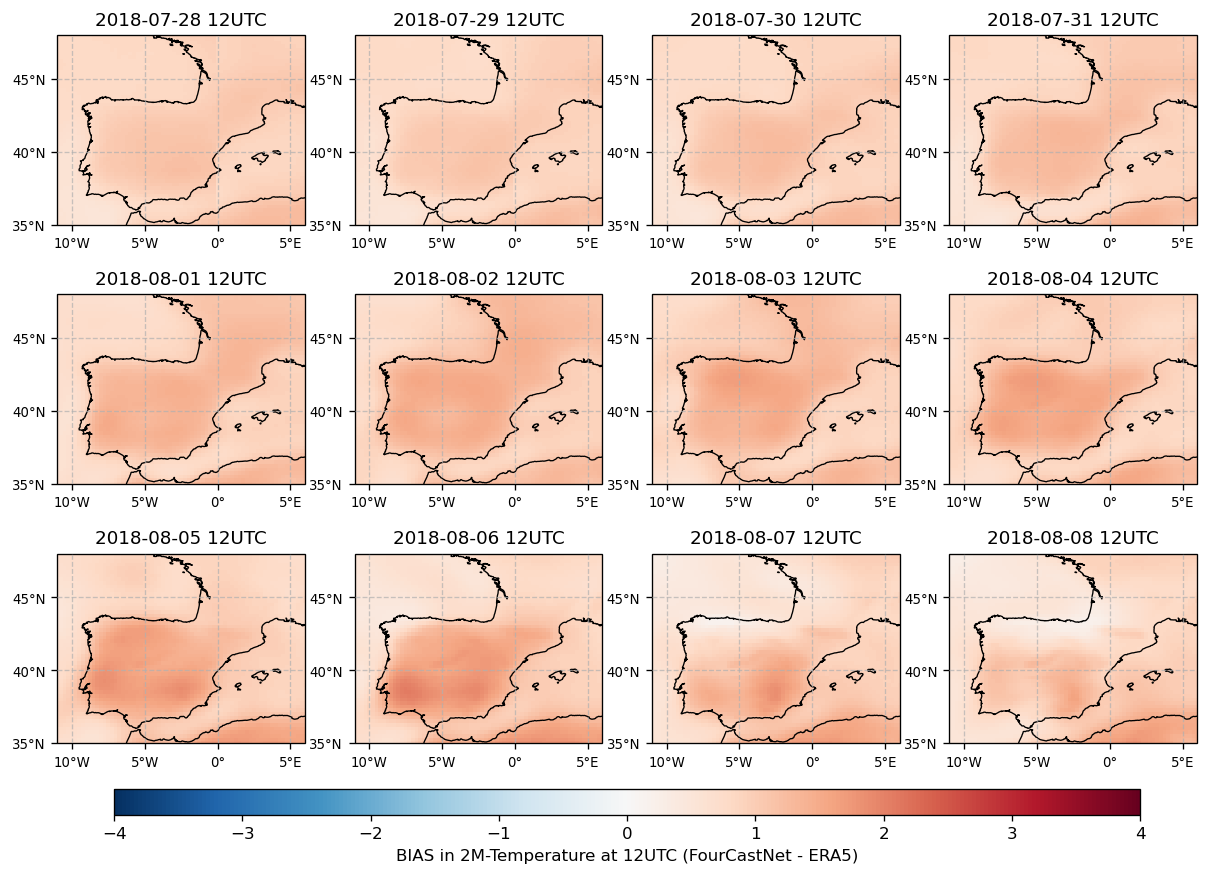

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

plt.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = 7, 7

data= t2m_ai_pgw_iberia 

# Create subplots with shared y-axis and manually share x-axis
f, axes = plt.subplots(3, 4, sharey=True, sharex=True, figsize=(10,8.5), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=0.0, globe=None)))

#lev = np.arange(-3,3.1,0.25)
lev = np.arange(16,42.1,1)
lev2 = np.arange(5300,6000,80)
colors = mpl.cm.get_cmap('RdBu_r', 256)
newcolors = colors(np.linspace(0, 1, 256))
white = np.array([1, 1, 1, 1])
newcolors[120:137, :] = white
newcmap = mpl.colors.ListedColormap(newcolors)

lat, lon = data.lat, data.lon
nLons = np.arange(-180, 181, 5)
nLats = np.arange(-90, 91, 5)

# Loop through subplots
for i, ax in enumerate(axes.flatten()):

    try:
        ax.set_title( data.time.dt.strftime('%Y-%m-%d %HUTC').values[i], fontsize=11)

        ax.set_xticks(nLons, crs=ccrs.PlateCarree())
        ax.set_yticks(nLats, crs=ccrs.PlateCarree())
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.set_ylim([35, 48])
        ax.set_xlim([-11, 6])
    
        ax.set_facecolor('0.9')
        ax.coastlines(lw=0.8, color='k')  
        ax.gridlines(linestyle='--', zorder=3, alpha=0.7, xlocs=nLons, ylocs=nLats)

        # format the ticks as e.g 60°W
        ax.xaxis.set_major_formatter(LongitudeFormatter())
        ax.yaxis.set_major_formatter(LatitudeFormatter())

        ax.set_aspect(1)

        # Explicitly pass the ax parameter to contourf
        #h = ax.contourf(lon, lat, data[i], cmap='Spectral_r', levels=lev, extend='both', alpha=1.0) 
        h = ax.pcolormesh(lon, lat, data[i], cmap='RdBu_r', vmax=4, vmin=-4)
    except:
        f.delaxes(axes.flatten()[i])

# Adjust size
f.subplots_adjust(hspace=0.2, wspace=0.2, left=0.0, right=0.95, bottom=0.05, top=0.95)

# Add common colorbar
cbar = plt.colorbar(h, ax=axes, label='BIAS in 2M-Temperature at 12UTC (FourCastNet - ERA5)', pad=0.05, orientation='horizontal', shrink=0.9, aspect=40)
#cbar = plt.colorbar(h, ax=axes, label='BIAS in 2M-Temperature at 12UTC FourcastNet (Factual - Counterfactual)', pad=0.05, orientation='horizontal', shrink=0.9, aspect=40)

#save figure
#plt.savefig('2018HW_Iberia_pannel_bias_FourCastNet_wrt_ERA5.pdf',bbox_inches='tight')
plt.savefig('2018HW_Iberia_pannel_diff_FourCastNet_factual-counterfactual_ERA5.pdf',bbox_inches='tight')

In [36]:
t2m_ai_max_iberia

<xarray.DataArray 't2m' (model: 12, init_time: 16, time: 19, lat: 81, lon: 81)> Size: 96MB
array([[[[[14.827454 , 14.87085  , 14.903656 , ..., 22.990051 ,
           23.602417 , 23.83313  ],
          [14.980957 , 15.013184 , 15.058685 , ..., 22.724487 ,
           23.359589 , 24.198578 ],
          [15.147705 , 15.175262 , 15.210846 , ..., 22.82602  ,
           23.215698 , 24.044739 ],
          ...,
          [21.203522 , 20.823425 , 20.448334 , ..., 42.938263 ,
           42.709656 , 42.672394 ],
          [21.071075 , 20.72342  , 20.349243 , ..., 43.033997 ,
           42.85019  , 42.75595  ],
          [20.989014 , 20.672577 , 20.365295 , ..., 43.173126 ,
           43.034332 , 42.967194 ]],

         [[15.455139 , 15.516388 , 15.604523 , ..., 23.6333   ,
           24.211731 , 24.342957 ],
          [15.776459 , 15.813965 , 15.892059 , ..., 23.766205 ,
           24.357147 , 24.949005 ],
          [16.086517 , 16.116302 , 16.15744  , ..., 24.082855 ,
           24.382294 , 24.99115  ],
...
          [21.305695 , 20.893616 , 20.446594 , ..., 38.66275  ,
           38.389587 , 38.17636  ],
          [21.166534 , 20.736847 , 20.286713 , ..., 38.77115  ,
           38.500732 , 38.338562 ],
          [21.033417 , 20.605835 , 20.155579 , ..., 38.890015 ,
           38.674072 , 38.48282  ]],

         [[16.589691 , 16.644104 , 16.670593 , ..., 22.723236 ,
           23.249054 , 23.378235 ],
          [16.696655 , 16.7182   , 16.794434 , ..., 23.002258 ,
           23.557007 , 24.05484  ],
          [16.763153 , 16.8172   , 16.880127 , ..., 23.379883 ,
           23.64569  , 24.163086 ],
          ...,
          [21.577179 , 21.167603 , 20.728455 , ..., 38.32315  ,
           38.03534  , 37.786102 ],
          [21.427582 , 20.99936  , 20.551361 , ..., 38.328217 ,
           38.040527 , 37.83908  ],
          [21.266418 , 20.819641 , 20.383148 , ..., 38.335632 ,
           38.10608  , 37.90149  ]]]]], dtype=float32)
Coordinates:
  * lat        (lat) float64 648B 50.0 49.75 49.5 49.25 ... 30.5 30.25 30.0
  * time       (time) datetime64[ns] 152B 2018-07-28T12:00:00 ... 2018-08-15T...
  * init_time  (init_time) datetime64[ns] 128B 2018-07-28 ... 2018-07-31T18:0...
  * model      (model) <U16 768B 'awi-cm-1-1-mr' 'bcc-csm2-mr' ... 'ec-earth3'
  * lon        (lon) float64 648B -12.0 -11.75 -11.5 -11.25 ... 7.5 7.75 8.0
    region     int64 8B 0
    abbrevs    <U3 12B 'lnd'
    names      <U4 16B 'land'
    land_mask  (lat, lon) int16 13kB 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1

In [38]:
ens_std_iberia = t2m_ai_max_iberia.std(['init_time','model'])
ens_std_iberia

<xarray.DataArray 't2m' (time: 19, lat: 81, lon: 81)> Size: 499kB
array([[[0.82207626, 0.8165479 , 0.8286107 , ..., 0.78870386,
         1.2576593 , 1.8791898 ],
        [0.7695537 , 0.77629745, 0.7909653 , ..., 1.5021913 ,
         2.0360196 , 1.9743482 ],
        [0.7483026 , 0.7552254 , 0.76648206, ..., 2.0656176 ,
         1.9472849 , 1.8893629 ],
        ...,
        [0.50619966, 0.47785756, 0.48289922, ..., 1.2812208 ,
         1.1217377 , 0.96351206],
        [0.4904716 , 0.48265964, 0.48804384, ..., 1.3030622 ,
         1.11224   , 0.97324073],
        [0.49034366, 0.48620304, 0.48861244, ..., 1.1631548 ,
         1.0367527 , 0.9272578 ]],

       [[0.6897544 , 0.6856227 , 0.68083036, ..., 0.92206174,
         0.9056204 , 0.91077775],
        [0.68082243, 0.6774262 , 0.6750245 , ..., 0.85992074,
         0.89866066, 0.9326752 ],
        [0.6754775 , 0.6710275 , 0.6653926 , ..., 0.9700154 ,
         0.94977134, 0.99533755],
...
        [0.31965667, 0.43327975, 0.5551507 , ..., 0.66344345,
         0.6752418 , 0.68604517],
        [0.35754585, 0.47837612, 0.6006639 , ..., 0.6891763 ,
         0.69963235, 0.7121084 ],
        [0.3893845 , 0.514489  , 0.6295697 , ..., 0.724441  ,
         0.7369943 , 0.74815416]],

       [[0.66901886, 0.67266613, 0.6667034 , ..., 1.4743357 ,
         1.4599826 , 1.459831  ],
        [0.66755015, 0.6644954 , 0.66304535, ..., 1.4510514 ,
         1.4477042 , 1.4489678 ],
        [0.66159445, 0.66146964, 0.66316634, ..., 1.4491013 ,
         1.4605085 , 1.4705391 ],
        ...,
        [0.20689626, 0.25772354, 0.3208222 , ..., 0.79691845,
         0.8213088 , 0.8444938 ],
        [0.21525063, 0.27078927, 0.3305897 , ..., 0.82409304,
         0.84594196, 0.8743998 ],
        [0.22378738, 0.28131565, 0.33930334, ..., 0.85805064,
         0.88406605, 0.9101856 ]]], dtype=float32)
Coordinates:
  * lat        (lat) float64 648B 50.0 49.75 49.5 49.25 ... 30.5 30.25 30.0
  * time       (time) datetime64[ns] 152B 2018-07-28T12:00:00 ... 2018-08-15T...
  * lon        (lon) float64 648B -12.0 -11.75 -11.5 -11.25 ... 7.5 7.75 8.0
    region     int64 8B 0
    abbrevs    <U3 12B 'lnd'
    names      <U4 16B 'land'
    land_mask  (lat, lon) int16 13kB 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1

/tmp/ipykernel_4171164/4171329849.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = mpl.cm.get_cmap('RdBu_r', 256)


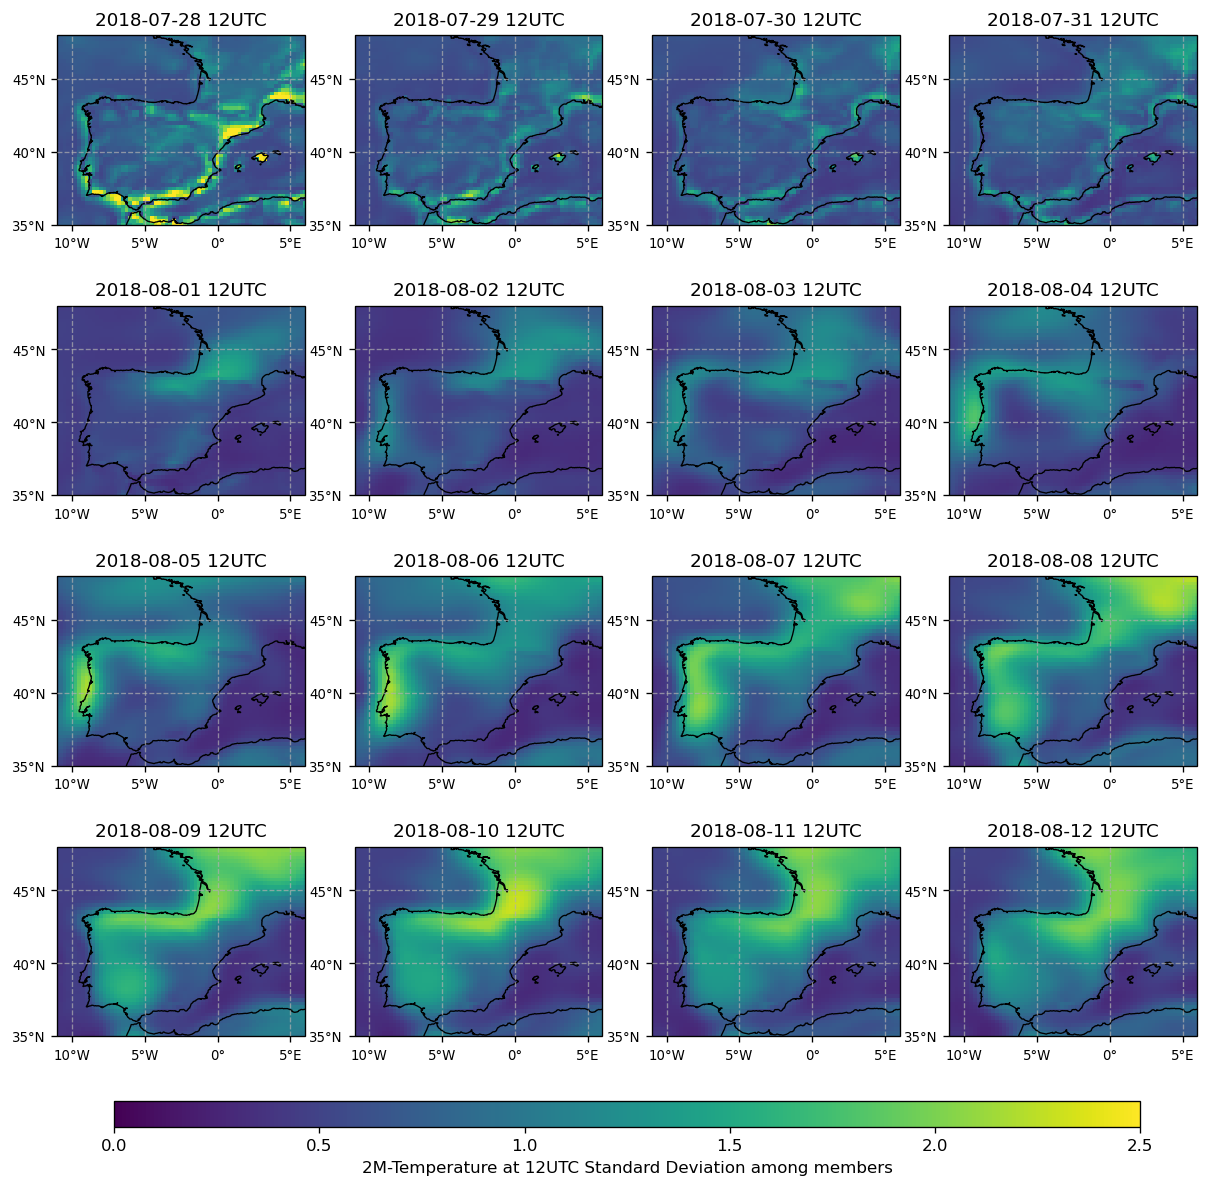

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

plt.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = 7, 7

data= ens_std_iberia 

# Create subplots with shared y-axis and manually share x-axis
f, axes = plt.subplots(3, 4, sharey=True, sharex=True, figsize=(10,12), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=0.0, globe=None)))

colors = mpl.cm.get_cmap('RdBu_r', 256)
newcolors = colors(np.linspace(0, 1, 256))
white = np.array([1, 1, 1, 1])
newcolors[120:137, :] = white
newcmap = mpl.colors.ListedColormap(newcolors)

lat, lon = data.lat, data.lon
nLons = np.arange(-180, 181, 5)
nLats = np.arange(-90, 91, 5)

# Loop through subplots
for i, ax in enumerate(axes.flatten()):

    try:
        ax.set_title( data.time.dt.strftime('%Y-%m-%d %HUTC').values[i], fontsize=11)

        ax.set_xticks(nLons, crs=ccrs.PlateCarree())
        ax.set_yticks(nLats, crs=ccrs.PlateCarree())
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.set_ylim([35, 48])
        ax.set_xlim([-11, 6])
    
        ax.set_facecolor('0.9')
        ax.coastlines(lw=0.8, color='k')  
        ax.gridlines(linestyle='--', zorder=3, alpha=0.7, xlocs=nLons, ylocs=nLats)

        # format the ticks as e.g 60°W
        ax.xaxis.set_major_formatter(LongitudeFormatter())
        ax.yaxis.set_major_formatter(LatitudeFormatter())

        ax.set_aspect(1)

        # Explicitly pass the ax parameter to contourf
        #h = ax.contourf(lon, lat, data[i], cmap='Spectral_r', levels=lev, extend='both', alpha=1.0) 
        h = ax.pcolormesh(lon, lat, data[i], cmap='viridis', vmax=2.5, vmin=0)
    except:
        f.delaxes(axes.flatten()[i])

# Adjust size
f.subplots_adjust(hspace=0.2, wspace=0.2, left=0.0, right=0.95, bottom=0.05, top=0.95)

# Add common colorbar
#cbar = plt.colorbar(h, ax=axes, label='BIAS in 2M-Temperature at 12UTC (FourCastNet - ERA5)', pad=0.05, orientation='horizontal', shrink=0.9, aspect=40)
cbar = plt.colorbar(h, ax=axes, label='2M-Temperature at 12UTC Standard Deviation among members', pad=0.05, orientation='horizontal', shrink=0.9, aspect=40)

#save figure
#plt.savefig('2018HW_Iberia_pannel_bias_FourCastNet_wrt_ERA5.pdf',bbox_inches='tight')
#plt.savefig('2018HW_Iberia_pannel_diff_FourCastNet_factual-counterfactual_ERA5.pdf',bbox_inches='tight')

In [40]:
def load_data_deltas(var, init_times, models):
    var_inits_model = []
    for model in models:
        print(model)
        var_inits = []
        for t0 in init_times:
            yyyymmddhh = t0.strftime('%Y%m%d%H')    
            file = f'/home/bernatj/Data/ai-forecasts/fcst/{yyyymmddhh}/{var}_fcnv2_PGW_{model}_{yyyymmddhh}.nc'
            ds = xr.open_dataset(file)[var]
            var_inits.append(ds)
        var_inits_model.append(xr.concat(var_inits, dim='init_time'))
    merged_dataset = xr.concat(var_inits_model, dim='model')

    return merged_dataset.assign_coords(init_time=init_times,model=models)

z500_cf = load_data_deltas('z500',init_times, models)

awi-cm-1-1-mr
bcc-csm2-mr
cams-csm1-0
canesm5-1
cas-esm2-0
cmcc-cm2-hr4
cmcc-cm2-sr5
cmcc-esm2
ec-earth3-cc
ec-earth3-veg-lr
ec-earth3-veg
ec-earth3


In [41]:
def load_data(var, init_times):
    var_inits = []
    for t0 in init_times:
        yyyymmddhh = t0.strftime('%Y%m%d%H')    
        file = f'/home/bernatj/Data/ai-forecasts/fcst/{yyyymmddhh}/{var}_fcnv2_{yyyymmddhh}.nc'
        ds = xr.open_dataset(file)[var]
        var_inits.append(ds)
    merged_dataset = xr.concat(var_inits, dim='init_time')
    return merged_dataset.assign_coords(init_time=init_times)

z500 = load_data('z500', init_times)

In [49]:
z500_ai_europe = flip_lon_360_2_180(z500[:,2::4],z500.lon).sel(lat=slice(70,20),lon=slice(-40,50)).mean('init_time') 
z500_ai_cf_europe = flip_lon_360_2_180(z500_cf[:,2::4],z500.lon).sel(lat=slice(70,20),lon=slice(-40,50)).mean(['init_time','model'])


In [50]:
diff_pgw_z500 = z500_ai_europe - z500_ai_cf_europe

/tmp/ipykernel_4171164/4249015176.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = mpl.cm.get_cmap('RdBu_r', 256)


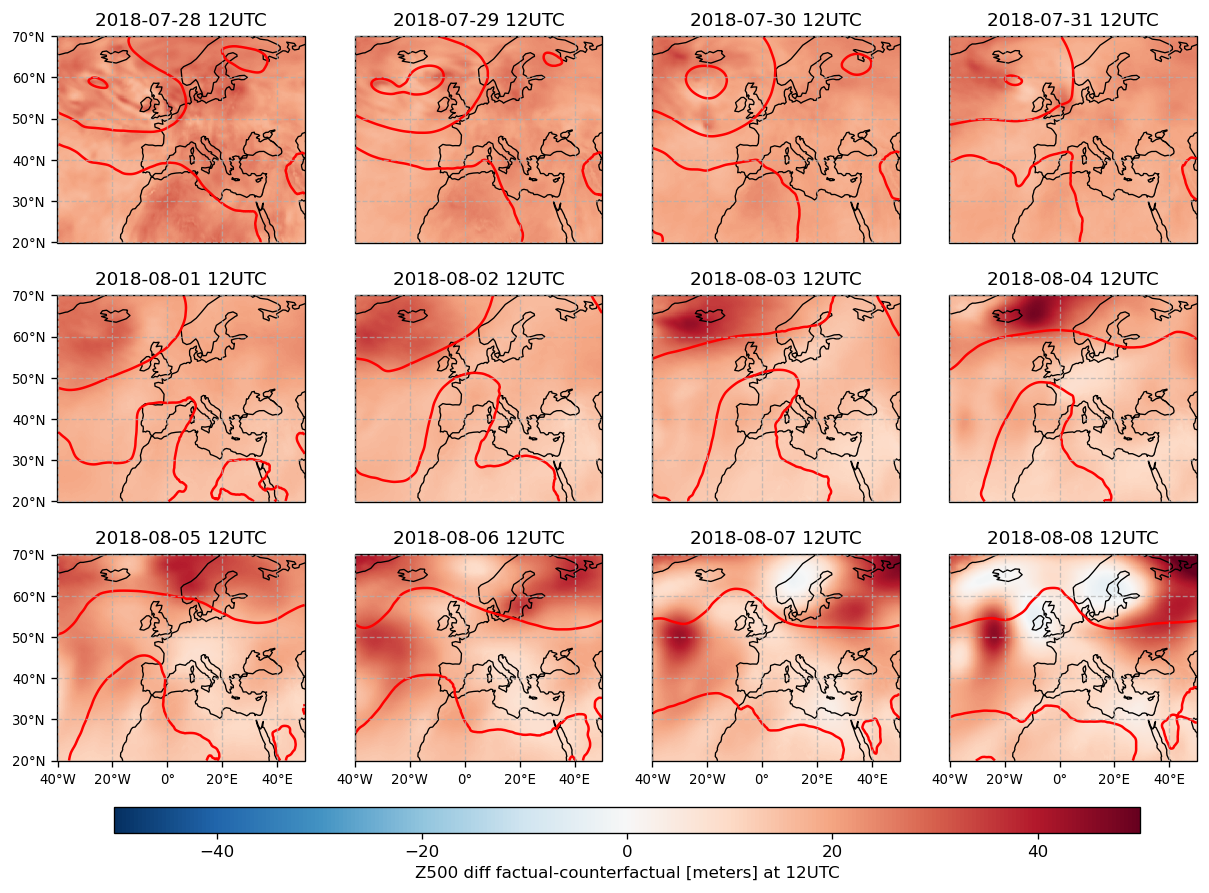

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

plt.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = 7, 7

data= diff_pgw_z500/9.806

# Create subplots with shared y-axis and manually share x-axis
f, axes = plt.subplots(3, 4, sharey=True, sharex=True, figsize=(10,8.5), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=0.0, globe=None)))

colors = mpl.cm.get_cmap('RdBu_r', 256)
newcolors = colors(np.linspace(0, 1, 256))
white = np.array([1, 1, 1, 1])
newcolors[120:137, :] = white
newcmap = mpl.colors.ListedColormap(newcolors)

lat, lon = data.lat, data.lon
nLons = np.arange(-180, 181, 20)
nLats = np.arange(-90, 91, 10)

# Loop through subplots
for i, ax in enumerate(axes.flatten()):

    try:
        ax.set_title( data.time.dt.strftime('%Y-%m-%d %HUTC').values[i], fontsize=11)

        if i%4 ==0:
            ax.set_yticks(nLats, crs=ccrs.PlateCarree())
        if i>=4*2:
            ax.set_xticks(nLons, crs=ccrs.PlateCarree())

        ax.tick_params(axis='both', which='major', labelsize=8)
    
        ax.set_facecolor('0.9')
        ax.coastlines(lw=0.8, color='k')  
        ax.gridlines(linestyle='--', zorder=3, alpha=0.7, xlocs=nLons, ylocs=nLats)

        # format the ticks as e.g 60°W
        ax.xaxis.set_major_formatter(LongitudeFormatter())
        ax.yaxis.set_major_formatter(LatitudeFormatter())

        ax.set_aspect(1.5)

        # Explicitly pass the ax parameter to contourf
        h = ax.contour(lon, lat, z500_ai_europe[i]/9.806, levels=[5400,5700,5900], colors='r') 
        h = ax.pcolormesh(lon, lat, data[i], cmap='RdBu_r', vmax=50, vmin=-50)
        
    except:
        f.delaxes(axes.flatten()[i])

# Adjust size
f.subplots_adjust(hspace=0.2, wspace=0.2, left=0.0, right=0.95, bottom=0.05, top=0.95)

# Add common colorbar
#cbar = plt.colorbar(h, ax=axes, label='BIAS in 2M-Temperature at 12UTC (FourCastNet - ERA5)', pad=0.05, orientation='horizontal', shrink=0.9, aspect=40)
cbar = plt.colorbar(h, ax=axes, label='Z500 diff factual-counterfactual [meters] at 12UTC', pad=0.05, orientation='horizontal', shrink=0.9, aspect=40)

#save figure
#plt.savefig('2018HW_Iberia_pannel_bias_FourCastNet_wrt_ERA5.pdf',bbox_inches='tight')
#plt.savefig('2018HW_Iberia_pannel_diff_FourCastNet_factual-counterfactual_ERA5.pdf',bbox_inches='tight'